In [33]:
import pandas as pd 
import numpy as np
import geopandas as gpd 
from datetime import datetime

# Set maximum number of rows and columns that can be viewed
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, ward

%reload_ext autoreload
%autoreload 2
from utils import *

In [2]:
# import shapefile into dataframe
# ny_shp = gpd.read_file("/content/drive/MyDrive/Datasets/DataKind/NY/ny_spdf/ny_spdf.shp")
ny_shp = gpd.read_file("data/NY/ny_spdf/ny_spdf.shp")
ny_shp.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,36,071,000502,1400000US36071000502,36071000502,5.02,CT,967431.0,969216.0,"POLYGON ((-74.02226 41.49281, -74.02180 41.496..."
1,36,103,135208,1400000US36103135208,36103135208,1352.08,CT,2287077.0,0.0,"POLYGON ((-73.28263 40.83063, -73.28157 40.832..."
2,36,047,057800,1400000US36047057800,36047057800,578,CT,172233.0,0.0,"POLYGON ((-73.95398 40.60140, -73.95304 40.601..."
3,36,047,058900,1400000US36047058900,36047058900,589,CT,424025.0,38353.0,"POLYGON ((-73.94605 40.72926, -73.94419 40.729..."
4,36,055,013204,1400000US36055013204,36055013204,132.04,CT,28207247.0,93541.0,"POLYGON ((-77.66835 43.02829, -77.66806 43.029..."


In [3]:
# sort dataframe by GEOID values
ny_shape = ny_shp.sort_values(by=['GEOID'])
ny_shape.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
539,36,001,000100,1400000US36001000100,36001000100,1,CT,2367456.0,245021.0,"POLYGON ((-73.74506 42.67228, -73.74374 42.677..."
2748,36,001,000200,1400000US36001000200,36001000200,2,CT,2065161.0,0.0,"POLYGON ((-73.75993 42.65997, -73.76156 42.660..."
3007,36,001,000300,1400000US36001000300,36001000300,3,CT,5758852.0,55326.0,"POLYGON ((-73.83021 42.69418, -73.82785 42.696..."
3515,36,001,000401,1400000US36001000401,36001000401,4.01,CT,9065815.0,86327.0,"POLYGON ((-73.89421 42.70977, -73.89668 42.711..."
2751,36,001,000403,1400000US36001000403,36001000403,4.03,CT,3138700.0,0.0,"POLYGON ((-73.82108 42.67857, -73.81916 42.680..."


In [4]:
# import database
# ny_acs = pd.read_csv('/content/drive/MyDrive/Datasets/DataKind/NY/acs_2019_NY.csv')
ny_acs = pd.read_csv('data/NY/acs_2019_NY.csv')
ny_acs.head(10)

,state,county,tract,geoid,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,state_lkp
0,36,1,100,36001000100,0.836,0.896,0.137,0.740,0.128,10.39,32389.0,2035.0,800.0,83.6,89.6,74.0,12.8,32389.0,13.7,800.0,717.0,669.0,2035.0,1506.0,2035.0,261.0,1283.0,176.0,717,669,717,0,669,48,83,2022,532,520,0,511,9,12,36
1,36,1,200,36001000200,0.767,0.903,0.225,0.845,0.043,10.23,27714.0,4793.0,2213.0,76.7,90.3,84.5,4.3,27714.0,22.5,2213.0,1999.0,1697.0,4793.0,4050.0,4793.0,206.0,2710.0,609.0,1999,1697,1999,0,1685,314,214,4711,1274,1221,0,1138,83,53,36
2,36,1,300,36001000300,0.819,0.881,0.289,0.435,0.121,10.72,45272.0,6147.0,2362.0,81.9,88.1,43.5,12.1,45272.0,28.9,2362.0,2081.0,1935.0,6147.0,2674.0,6147.0,742.0,3725.0,1078.0,2081,1935,2081,11,1917,153,281,5925,1729,1717,0,1630,87,12,36
3,36,1,401,36001000401,0.837,0.857,0.476,0.076,0.046,11.22,74274.0,2362.0,997.0,83.7,85.7,7.6,4.6,74274.0,47.6,997.0,854.0,834.0,2362.0,180.0,2362.0,109.0,2169.0,1032.0,854,834,854,0,826,28,143,1790,171,171,0,171,0,0,36
4,36,1,403,36001000403,0.817,0.861,0.591,0.129,0.058,11.22,74426.0,4253.0,2186.0,81.7,86.1,12.9,5.8,74426.0,59.1,2186.0,1882.0,1786.0,4253.0,548.0,4253.0,246.0,3220.0,1904.0,1882,1786,1882,0,1733,149,304,4240,462,462,0,462,0,0,36
5,36,1,404,36001000404,1.000,1.000,0.073,0.225,0.190,NaN,-666666666.0,5082.0,15.0,100.0,100.0,22.5,19.0,-666666666.0,7.3,15.0,15.0,15.0,5082.0,1143.0,5082.0,965.0,55.0,4.0,15,15,15,0,15,0,0,15,0,0,0,0,0,0,36
6,36,1,501,36001000501,0.718,0.811,0.228,0.439,0.226,10.38,32165.0,3523.0,1433.0,71.8,81.1,43.9,22.6,32165.0,22.8,1433.0,1162.0,1029.0,3523.0,1547.0,3523.0,795.0,2192.0,499.0,1162,1029,1162,0,1018,144,271,3440,917,881,0,721,160,36,36
7,36,1,502,36001000502,0.806,0.945,0.621,0.201,0.106,11.01,60263.0,3785.0,942.0,80.6,94.5,20.1,10.6,60263.0,62.1,942.0,890.0,759.0,3785.0,761.0,3785.0,402.0,1171.0,727.0,890,759,890,0,759,131,52,1892,212,212,0,183,29,0,36
8,36,1,600,36001000600,0.747,0.912,0.183,0.363,0.137,10.01,22298.0,3663.0,1408.0,74.7,91.2,36.3,13.7,22298.0,18.3,1408.0,1284.0,1052.0,3663.0,1328.0,3663.0,502.0,1742.0,319.0,1284,1052,1284,20,1052,212,124,3565,865,705,0,659,46,160,36
9,36,1,700,36001000700,0.751,0.834,0.167,0.807,0.099,10.51,36639.0,3885.0,1485.0,75.1,83.4,80.7,9.9,36639.0,16.7,1485.0,1238.0,1115.0,3885.0,3136.0,3885.0,386.0,2442.0,409.0,1238,1115,1238,18,1087,133,247,3868,1054,984,0,921,63,70,36


In [5]:
# eliminate negative fill-in values (-666666.00)
ny_acs[ny_acs < 0] = np.nan

In [6]:
ny_acs['geoid'] = ny_acs['geoid'].apply(lambda x: str(x))

In [8]:
joined_df = ny_shape.merge(ny_acs, how='left', left_on='GEOID', right_on='geoid')
joined_df.drop(columns=['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geoid'], inplace=True)
joined_df.head()

,GEOID,geometry,state,county,tract,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,state_lkp
0,36001000100,"POLYGON ((-73.74506 42.67228, -73.74374 42.677...",36,1,100,0.836,0.896,0.137,0.740,0.128,10.39,32389.0,2035.0,800.0,83.6,89.6,74.0,12.8,32389.0,13.7,800.0,717.0,669.0,2035.0,1506.0,2035.0,261.0,1283.0,176.0,717,669,717,0,669,48,83,2022,532,520,0,511,9,12,36
1,36001000200,"POLYGON ((-73.75993 42.65997, -73.76156 42.660...",36,1,200,0.767,0.903,0.225,0.845,0.043,10.23,27714.0,4793.0,2213.0,76.7,90.3,84.5,4.3,27714.0,22.5,2213.0,1999.0,1697.0,4793.0,4050.0,4793.0,206.0,2710.0,609.0,1999,1697,1999,0,1685,314,214,4711,1274,1221,0,1138,83,53,36
2,36001000300,"POLYGON ((-73.83021 42.69418, -73.82785 42.696...",36,1,300,0.819,0.881,0.289,0.435,0.121,10.72,45272.0,6147.0,2362.0,81.9,88.1,43.5,12.1,45272.0,28.9,2362.0,2081.0,1935.0,6147.0,2674.0,6147.0,742.0,3725.0,1078.0,2081,1935,2081,11,1917,153,281,5925,1729,1717,0,1630,87,12,36
3,36001000401,"POLYGON ((-73.89421 42.70977, -73.89668 42.711...",36,1,401,0.837,0.857,0.476,0.076,0.046,11.22,74274.0,2362.0,997.0,83.7,85.7,7.6,4.6,74274.0,47.6,997.0,854.0,834.0,2362.0,180.0,2362.0,109.0,2169.0,1032.0,854,834,854,0,826,28,143,1790,171,171,0,171,0,0,36
4,36001000403,"POLYGON ((-73.82108 42.67857, -73.81916 42.680...",36,1,403,0.817,0.861,0.591,0.129,0.058,11.22,74426.0,4253.0,2186.0,81.7,86.1,12.9,5.8,74426.0,59.1,2186.0,1882.0,1786.0,4253.0,548.0,4253.0,246.0,3220.0,1904.0,1882,1786,1882,0,1733,149,304,4240,462,462,0,462,0,0,36


In [9]:
# importing FCC database
# ny_fcc = pd.read_csv('/content/drive/MyDrive/Datasets/DataKind/NY/fcc_477_census_tract_NY.csv')
ny_fcc = pd.read_csv('data/NY/fcc_477_census_tract_NY.csv')
ny_fcc.head()

,tract,max_dn,max_up,dn10,dn100,dn250,fiber_100u,state
0,36001000100,711.250000,50.722222,1.875000,0.777778,0.777778,0.027778,36
1,36001000200,940.000000,35.000000,2.529412,1.011765,1.000000,0.000000,36
2,36001000300,928.040541,98.195946,2.290541,1.060811,1.060811,0.074324,36
3,36001000401,928.975904,65.168675,2.156627,1.024096,1.024096,0.036145,36
4,36001000403,940.000000,43.203883,2.310680,1.009709,1.009709,0.009709,36


In [10]:
# change tract column to string type for joining
ny_fcc['tract'] = ny_fcc['tract'].apply(lambda x: str(x))
type(ny_fcc['tract'][0])

str

In [11]:
# merge two database on geoid
joined_2 = joined_df.merge(ny_fcc, how='left', left_on='GEOID', right_on='tract')
joined_2.head()

,GEOID,geometry,state_x,county,tract_x,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,state_lkp,tract_y,max_dn,max_up,dn10,dn100,dn250,fiber_100u,state_y
0,36001000100,"POLYGON ((-73.74506 42.67228, -73.74374 42.677...",36,1,100,0.836,0.896,0.137,0.740,0.128,10.39,32389.0,2035.0,800.0,83.6,89.6,74.0,12.8,32389.0,13.7,800.0,717.0,669.0,2035.0,1506.0,2035.0,261.0,1283.0,176.0,717,669,717,0,669,48,83,2022,532,520,0,511,9,12,36,36001000100,711.250000,50.722222,1.875000,0.777778,0.777778,0.027778,36.0
1,36001000200,"POLYGON ((-73.75993 42.65997, -73.76156 42.660...",36,1,200,0.767,0.903,0.225,0.845,0.043,10.23,27714.0,4793.0,2213.0,76.7,90.3,84.5,4.3,27714.0,22.5,2213.0,1999.0,1697.0,4793.0,4050.0,4793.0,206.0,2710.0,609.0,1999,1697,1999,0,1685,314,214,4711,1274,1221,0,1138,83,53,36,36001000200,940.000000,35.000000,2.529412,1.011765,1.000000,0.000000,36.0
2,36001000300,"POLYGON ((-73.83021 42.69418, -73.82785 42.696...",36,1,300,0.819,0.881,0.289,0.435,0.121,10.72,45272.0,6147.0,2362.0,81.9,88.1,43.5,12.1,45272.0,28.9,2362.0,2081.0,1935.0,6147.0,2674.0,6147.0,742.0,3725.0,1078.0,2081,1935,2081,11,1917,153,281,5925,1729,1717,0,1630,87,12,36,36001000300,928.040541,98.195946,2.290541,1.060811,1.060811,0.074324,36.0
3,36001000401,"POLYGON ((-73.89421 42.70977, -73.89668 42.711...",36,1,401,0.837,0.857,0.476,0.076,0.046,11.22,74274.0,2362.0,997.0,83.7,85.7,7.6,4.6,74274.0,47.6,997.0,854.0,834.0,2362.0,180.0,2362.0,109.0,2169.0,1032.0,854,834,854,0,826,28,143,1790,171,171,0,171,0,0,36,36001000401,928.975904,65.168675,2.156627,1.024096,1.024096,0.036145,36.0
4,36001000403,"POLYGON ((-73.82108 42.67857, -73.81916 42.680...",36,1,403,0.817,0.861,0.591,0.129,0.058,11.22,74426.0,4253.0,2186.0,81.7,86.1,12.9,5.8,74426.0,59.1,2186.0,1882.0,1786.0,4253.0,548.0,4253.0,246.0,3220.0,1904.0,1882,1786,1882,0,1733,149,304,4240,462,462,0,462,0,0,36,36001000403,940.000000,43.203883,2.310680,1.009709,1.009709,0.009709,36.0


In [12]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url

In [13]:
# the files take some time to download (>5 minutes)
# fixed_url = get_tile_url("fixed", 2019, 1)
fixed_ookla_shp = gpd.read_file('data/national/ookla-data/2019-01-01_performance_fixed_tiles/gps_fixed_tiles.shp')
fixed_ookla_shp.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,0231113112003202,66216,12490,13,28,4,"POLYGON ((-90.65918 38.49229, -90.65369 38.492..."
1,1322111021111001,102598,37356,13,15,4,"POLYGON ((110.35217 21.28937, 110.35767 21.289..."
2,3112203030003110,24686,18736,18,162,106,"POLYGON ((138.59253 -34.92197, 138.59802 -34.9..."
3,0320000130321312,17674,13989,78,364,4,"POLYGON ((-87.63794 40.22502, -87.63245 40.225..."
4,0320001332313103,441192,218955,22,14,1,"POLYGON ((-84.74304 38.92096, -84.73755 38.920..."


In [16]:
fixed_ookla_shp.to_file('data/national/fixed_ookla_012019.geojson', driver="GeoJSON")

In [14]:
# mobile_url = get_tile_url("mobile", 2019, 1)
# mobile_ookla_shp = gpd.read_file(mobile_url)
mobile_ookla_shp = gpd.read_file('data/national/ookla-data/2019-01-01_performance_mobile_tiles/gps_mobile_tiles.shp')
mobile_ookla_shp.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1202130120303121,12503,5090,43,1,1,"POLYGON ((18.52844 51.91039, 18.53394 51.91039..."
1,0322113021201023,16109,11204,36,98,49,"POLYGON ((-69.91150 18.46398, -69.90601 18.463..."
2,3100130002212100,10325,7378,46,94,34,"POLYGON ((106.98486 -6.18425, 106.99036 -6.184..."
3,1231213031333131,7187,2051,50,211,104,"POLYGON ((77.33826 28.64239, 77.34375 28.64239..."
4,0230102031111210,76282,20332,27,2,2,"POLYGON ((-122.37671 38.25544, -122.37122 38.2..."


In [16]:
mobile_ookla_shp.to_file('data/national/ookla-data/mobile_ookla_012019.geojson', driver="GeoJSON")

In [22]:
us_tracts = gpd.read_file('data/national/Census Tract Shapefiles/cb_2019_us_tract_500k/cb_2019_us_tract_500k.shp')
# us_tracts = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/DataKind/cb_2019_us_tract_500k/cb_2019_us_tract_500k.shp')

In [23]:
ny_tracts = us_tracts[us_tracts['STATEFP']=='36']
ny_tracts = ny_tracts.to_crs("EPSG:4326")
ny_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
2,36,071,000502,1400000US36071000502,36071000502,5.02,CT,967431,969216,"POLYGON ((-74.02226 41.49281, -74.02180 41.496..."
10,36,103,135208,1400000US36103135208,36103135208,1352.08,CT,2287077,0,"POLYGON ((-73.28263 40.83063, -73.28157 40.832..."
49,36,047,057800,1400000US36047057800,36047057800,578,CT,172233,0,"POLYGON ((-73.95398 40.60140, -73.95304 40.601..."
50,36,047,058900,1400000US36047058900,36047058900,589,CT,424025,38353,"POLYGON ((-73.94605 40.72926, -73.94419 40.729..."
53,36,055,013204,1400000US36055013204,36055013204,132.04,CT,28207247,93541,"POLYGON ((-77.66835 43.02829, -77.66806 43.029..."


In [ ]:
fixed_ookla_shp = fixed_ookla_shp.to_crs("EPSG:4326")
fixed_ookla_shp['centroid'] = fixed_ookla_shp.centroid
mobile_ookla_shp = mobile_ookla_shp.to_crs("EPSG:4326")
mobile_ookla_shp['centroid'] = mobile_ookla_shp.centroid

fixed_ookla_shp.set_geometry('centroid')
fixed_bb_ny_2 = gpd.sjoin(fixed_ookla_shp, ny_tracts, op='intersects', how='inner')
fixed_bb_ny_2.head()
fixed_bb_ny_2.drop(columns=['centroid'], inplace=True)
fixed_bb_ny_2 = fixed_bb_ny_2.reset_index(drop=True)
fixed_bb_ny_2.head()

In [ ]:
mobile_ookla_shp.set_geometry('centroid')
mobile_bb_ny_2 = gpd.sjoin(mobile_ookla_shp, ny_tracts, how='inner', op='intersects')
mobile_bb_ny_2.head()
mobile_bb_ny_2.drop(columns=['centroid'], inplace=True)
mobile_bb_ny_2 = mobile_bb_ny_2.reset_index(drop=True)
mobile_bb_ny_2.head()

In [19]:
mobile_ookla = gpd.read_file('data/NY/geojson/mobile_bb_ny_2.geojson')
mobile_ookla.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,index_right,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,0320101101302301,44327,11950,34,61,22,7372,36,061,018100,1400000US36061018100,36061018100,181,CT,138438,0,"POLYGON ((-73.97644 40.79718, -73.97095 40.797..."
1,0320101101302303,67156,18470,35,61,25,7372,36,061,018100,1400000US36061018100,36061018100,181,CT,138438,0,"POLYGON ((-73.97644 40.79302, -73.97095 40.793..."
2,0320101101302312,42945,10367,27,54,22,7372,36,061,018100,1400000US36061018100,36061018100,181,CT,138438,0,"POLYGON ((-73.97095 40.79302, -73.96545 40.793..."
3,0320101101302310,72812,10699,45,30,13,7372,36,061,018100,1400000US36061018100,36061018100,181,CT,138438,0,"POLYGON ((-73.97095 40.79718, -73.96545 40.797..."
4,0320101101302313,53723,11901,109,5,3,7372,36,061,018100,1400000US36061018100,36061018100,181,CT,138438,0,"POLYGON ((-73.96545 40.79302, -73.95996 40.793..."


In [21]:
mobile_ookla = mobile_ookla[['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'GEOID']]
mobile_ookla.head()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,GEOID
0,44327,11950,34,61,22,36061018100
1,67156,18470,35,61,25,36061018100
2,42945,10367,27,54,22,36061018100
3,72812,10699,45,30,13,36061018100
4,53723,11901,109,5,3,36061018100


In [20]:
fixed_ookla = gpd.read_file('data/NY/geojson/fixed_bb_ny_2.geojson')
fixed_ookla.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,index_right,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,0320101101323112,136203,40848,11,248,97,1075,36,081,018501,1400000US36081018501,36081018501,185.01,CT,98522,0,"POLYGON ((-73.92700 40.74310, -73.92151 40.743..."
1,0320101101323130,153640,63816,10,268,70,1075,36,081,018501,1400000US36081018501,36081018501,185.01,CT,98522,0,"POLYGON ((-73.92700 40.73893, -73.92151 40.738..."
2,0320101101323113,156486,51539,12,266,82,1075,36,081,018501,1400000US36081018501,36081018501,185.01,CT,98522,0,"POLYGON ((-73.92151 40.74310, -73.91602 40.743..."
3,0320101101323131,158302,45390,11,274,75,1075,36,081,018501,1400000US36081018501,36081018501,185.01,CT,98522,0,"POLYGON ((-73.92151 40.73893, -73.91602 40.738..."
4,0320101101323112,136203,40848,11,248,97,59157,36,081,018900,1400000US36081018900,36081018900,189,CT,217707,0,"POLYGON ((-73.92700 40.74310, -73.92151 40.743..."


In [24]:
fixed_ookla = fixed_ookla[['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'GEOID']]

In [25]:
wm = lambda x: np.average(x, weights=mobile_ookla.loc[x.index, 'tests'])

mobile_agg = mobile_ookla.groupby(['GEOID'], as_index=False).agg(
                                    m_d_kbps_wm = ('avg_d_kbps', wm),
                                    m_u_kbps_wm = ('avg_u_kbps', wm),
                                    m_tests = ('tests', sum),
                                    m_devices = ('devices', sum)
                                    )
mobile_agg.head()

,GEOID,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices
0,36001000100,33798.250000,9721.850000,20,15
1,36001000200,25220.151515,10305.969697,66,34
2,36001000300,46350.592105,11667.434211,76,51
3,36001000401,48040.646018,15980.106195,113,40
4,36001000403,51088.952381,11992.500000,42,28


In [26]:
wm = lambda x: np.average(x, weights=fixed_ookla.loc[x.index, 'tests'])

fixed_agg = fixed_ookla.groupby(['GEOID'], as_index=False).agg(
                                  f_d_kbps_wm = ('avg_d_kbps', wm),
                                  f_u_kbps_wm = ('avg_u_kbps', wm),
                                  f_tests = ('tests', sum),
                                  f_devices = ('devices', sum)
                                  )
fixed_agg.head()

,GEOID,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,36001000100,53064.355263,13516.934211,76,29
1,36001000200,82315.136364,11795.281818,110,61
2,36001000300,61513.941704,9973.273543,223,87
3,36001000401,87434.738462,49736.338462,65,39
4,36001000403,86733.135135,13435.054054,185,86


In [27]:
df_ookla = mobile_agg.merge(fixed_agg, how='outer', on='GEOID')
df_ookla['GEOID'] = df_ookla['GEOID'].apply(lambda x: str(x))
df_ookla.head()

,GEOID,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,36001000100,33798.250000,9721.850000,20.0,15.0,53064.355263,13516.934211,76,29
1,36001000200,25220.151515,10305.969697,66.0,34.0,82315.136364,11795.281818,110,61
2,36001000300,46350.592105,11667.434211,76.0,51.0,61513.941704,9973.273543,223,87
3,36001000401,48040.646018,15980.106195,113.0,40.0,87434.738462,49736.338462,65,39
4,36001000403,51088.952381,11992.500000,42.0,28.0,86733.135135,13435.054054,185,86


In [67]:
joined_3 = joined_2.merge(df_ookla, how='left', on='GEOID')
joined_3.head()

,GEOID,geometry,state_x,county,tract_x,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,state_lkp,tract_y,max_dn,max_up,dn10,dn100,dn250,fiber_100u,state_y,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,36001000100,"POLYGON ((-73.74506 42.67228, -73.74374 42.677...",36,1,100,0.836,0.896,0.137,0.740,0.128,10.39,32389.0,2035.0,800.0,83.6,89.6,74.0,12.8,32389.0,13.7,800.0,717.0,669.0,2035.0,1506.0,2035.0,261.0,1283.0,176.0,717,669,717,0,669,48,83,2022,532,520,0,511,9,12,36,36001000100,711.250000,50.722222,1.875000,0.777778,0.777778,0.027778,36.0,33798.250000,9721.850000,20.0,15.0,53064.355263,13516.934211,76.0,29.0
1,36001000200,"POLYGON ((-73.75993 42.65997, -73.76156 42.660...",36,1,200,0.767,0.903,0.225,0.845,0.043,10.23,27714.0,4793.0,2213.0,76.7,90.3,84.5,4.3,27714.0,22.5,2213.0,1999.0,1697.0,4793.0,4050.0,4793.0,206.0,2710.0,609.0,1999,1697,1999,0,1685,314,214,4711,1274,1221,0,1138,83,53,36,36001000200,940.000000,35.000000,2.529412,1.011765,1.000000,0.000000,36.0,25220.151515,10305.969697,66.0,34.0,82315.136364,11795.281818,110.0,61.0
2,36001000300,"POLYGON ((-73.83021 42.69418, -73.82785 42.696...",36,1,300,0.819,0.881,0.289,0.435,0.121,10.72,45272.0,6147.0,2362.0,81.9,88.1,43.5,12.1,45272.0,28.9,2362.0,2081.0,1935.0,6147.0,2674.0,6147.0,742.0,3725.0,1078.0,2081,1935,2081,11,1917,153,281,5925,1729,1717,0,1630,87,12,36,36001000300,928.040541,98.195946,2.290541,1.060811,1.060811,0.074324,36.0,46350.592105,11667.434211,76.0,51.0,61513.941704,9973.273543,223.0,87.0
3,36001000401,"POLYGON ((-73.89421 42.70977, -73.89668 42.711...",36,1,401,0.837,0.857,0.476,0.076,0.046,11.22,74274.0,2362.0,997.0,83.7,85.7,7.6,4.6,74274.0,47.6,997.0,854.0,834.0,2362.0,180.0,2362.0,109.0,2169.0,1032.0,854,834,854,0,826,28,143,1790,171,171,0,171,0,0,36,36001000401,928.975904,65.168675,2.156627,1.024096,1.024096,0.036145,36.0,48040.646018,15980.106195,113.0,40.0,87434.738462,49736.338462,65.0,39.0
4,36001000403,"POLYGON ((-73.82108 42.67857, -73.81916 42.680...",36,1,403,0.817,0.861,0.591,0.129,0.058,11.22,74426.0,4253.0,2186.0,81.7,86.1,12.9,5.8,74426.0,59.1,2186.0,1882.0,1786.0,4253.0,548.0,4253.0,246.0,3220.0,1904.0,1882,1786,1882,0,1733,149,304,4240,462,462,0,462,0,0,36,36001000403,940.000000,43.203883,2.310680,1.009709,1.009709,0.009709,36.0,51088.952381,11992.500000,42.0,28.0,86733.135135,13435.054054,185.0,86.0


In [94]:
joined_3.GEOID.value_counts()

36001000100    1
36081018502    1
36081019400    1
36081019200    1
36081019000    1
              ..
36047067000    1
36047066600    1
36047066200    1
36047066000    1
36123150500    1
Name: GEOID, Length: 4906, dtype: int64

In [68]:
joined_3.columns

Index(['GEOID', 'geometry', 'state_x', 'county', 'tract_x', 'f_broadband',
       'f_computer', 'f_ba', 'f_black', 'f_hispanic', 'log_mhi', 'mhi',
       'population', 'households', 'broadband', 'computer', 'black',
       'hispanic', 'mhi.1', 'ba', 'den_computers', 'n_computer', 'n_broadband',
       'den_black', 'n_black', 'den_hispanic', 'n_hispanic', 'den_ba', 'n_ba',
       'nhh_computer', 'nhh_broadband', 'nhh_computer_any_internet',
       'nhh_computer_and_dialup', 'nhh_computer_and_broadband',
       'nhh_computer_no_internet', 'nhh_no_computer', 'den_age', 'n_children',
       'n_children_computer', 'n_children_computer_and_dialup',
       'n_children_computer_and_broadband', 'n_children_computer_no_internet',
       'n_children_no_computer', 'state_lkp', 'tract_y', 'max_dn', 'max_up',
       'dn10', 'dn100', 'dn250', 'fiber_100u', 'state_y', 'm_d_kbps_wm',
       'm_u_kbps_wm', 'm_tests', 'm_devices', 'f_d_kbps_wm', 'f_u_kbps_wm',
       'f_tests', 'f_devices'],
      dtype=

In [69]:
joined_3.drop(columns=['state_x', 'county', 'tract_x', 'state_lkp', 'tract_y', 'state_y'], inplace=True)
joined_3.head()

,GEOID,geometry,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,max_dn,max_up,dn10,dn100,dn250,fiber_100u,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,36001000100,"POLYGON ((-73.74506 42.67228, -73.74374 42.677...",0.836,0.896,0.137,0.740,0.128,10.39,32389.0,2035.0,800.0,83.6,89.6,74.0,12.8,32389.0,13.7,800.0,717.0,669.0,2035.0,1506.0,2035.0,261.0,1283.0,176.0,717,669,717,0,669,48,83,2022,532,520,0,511,9,12,711.250000,50.722222,1.875000,0.777778,0.777778,0.027778,33798.250000,9721.850000,20.0,15.0,53064.355263,13516.934211,76.0,29.0
1,36001000200,"POLYGON ((-73.75993 42.65997, -73.76156 42.660...",0.767,0.903,0.225,0.845,0.043,10.23,27714.0,4793.0,2213.0,76.7,90.3,84.5,4.3,27714.0,22.5,2213.0,1999.0,1697.0,4793.0,4050.0,4793.0,206.0,2710.0,609.0,1999,1697,1999,0,1685,314,214,4711,1274,1221,0,1138,83,53,940.000000,35.000000,2.529412,1.011765,1.000000,0.000000,25220.151515,10305.969697,66.0,34.0,82315.136364,11795.281818,110.0,61.0
2,36001000300,"POLYGON ((-73.83021 42.69418, -73.82785 42.696...",0.819,0.881,0.289,0.435,0.121,10.72,45272.0,6147.0,2362.0,81.9,88.1,43.5,12.1,45272.0,28.9,2362.0,2081.0,1935.0,6147.0,2674.0,6147.0,742.0,3725.0,1078.0,2081,1935,2081,11,1917,153,281,5925,1729,1717,0,1630,87,12,928.040541,98.195946,2.290541,1.060811,1.060811,0.074324,46350.592105,11667.434211,76.0,51.0,61513.941704,9973.273543,223.0,87.0
3,36001000401,"POLYGON ((-73.89421 42.70977, -73.89668 42.711...",0.837,0.857,0.476,0.076,0.046,11.22,74274.0,2362.0,997.0,83.7,85.7,7.6,4.6,74274.0,47.6,997.0,854.0,834.0,2362.0,180.0,2362.0,109.0,2169.0,1032.0,854,834,854,0,826,28,143,1790,171,171,0,171,0,0,928.975904,65.168675,2.156627,1.024096,1.024096,0.036145,48040.646018,15980.106195,113.0,40.0,87434.738462,49736.338462,65.0,39.0
4,36001000403,"POLYGON ((-73.82108 42.67857, -73.81916 42.680...",0.817,0.861,0.591,0.129,0.058,11.22,74426.0,4253.0,2186.0,81.7,86.1,12.9,5.8,74426.0,59.1,2186.0,1882.0,1786.0,4253.0,548.0,4253.0,246.0,3220.0,1904.0,1882,1786,1882,0,1733,149,304,4240,462,462,0,462,0,0,940.000000,43.203883,2.310680,1.009709,1.009709,0.009709,51088.952381,11992.500000,42.0,28.0,86733.135135,13435.054054,185.0,86.0


In [70]:
joined_3.isna().sum()

GEOID                                  0
geometry                               0
f_broadband                           78
f_computer                            78
f_ba                                  56
f_black                               52
f_hispanic                            52
log_mhi                              121
mhi                                  121
population                             0
households                             0
broadband                             78
computer                              78
black                                 52
hispanic                              52
mhi.1                                121
ba                                    56
den_computers                          0
n_computer                             0
n_broadband                            0
den_black                              0
n_black                                0
den_hispanic                           0
n_hispanic                             0
den_ba          

In [71]:
census = pd.read_excel('data/NY/nyc_2020_census_tract_nta_cdta_relationships.xlsx')
census.GEOID = census.GEOID.apply(lambda x: str(x))
census.head()

,GEOID,CountyFIPS,BoroCode,BoroName,BoroCT2020,CT2020,CTLabel,NTACode,NTAType,NTAName,NTAAbbrev,CDTACode,CDTAType,CDTAName
0,36005001901,5,2,Bronx,2001901,1901,19.01,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
1,36005001902,5,2,Bronx,2001902,1902,19.02,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
2,36005001903,5,2,Bronx,2001903,1903,19.03,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
3,36005002300,5,2,Bronx,2002300,2300,23.00,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...
4,36005002500,5,2,Bronx,2002500,2500,25.00,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...


In [103]:
census.GEOID.count()

2327

In [114]:
joined_4 = census.merge(joined_3, how='left', on='GEOID')
joined_4.head()

,GEOID,CountyFIPS,BoroCode,BoroName,BoroCT2020,CT2020,CTLabel,NTACode,NTAType,NTAName,NTAAbbrev,CDTACode,CDTAType,CDTAName,geometry,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,max_dn,max_up,dn10,dn100,dn250,fiber_100u,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,36005001901,5,2,Bronx,2001901,1901,19.01,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36005001902,5,2,Bronx,2001902,1902,19.02,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36005001903,5,2,Bronx,2001903,1903,19.03,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36005002300,5,2,Bronx,2002300,2300,23.00,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,"POLYGON ((-73.92922 40.80956, -73.92813 40.809...",0.546,0.664,0.093,0.387,0.712,9.84,18688.0,4302.0,1914.0,54.6,66.4,38.7,71.2,18688.0,9.3,1914.0,1270.0,1045.0,4302.0,1664.0,4302.0,3062.0,2754.0,255.0,1270.0,1045.0,1270.0,0.0,1023.0,247.0,644.0,4297.0,861.0,805.0,0.0,741.0,64.0,56.0,872.0,774.0,2.700,1.800,1.700,0.800,33986.211268,11544.042254,71.0,40.0,133804.347541,60257.154098,305.0,105.0
4,36005002500,5,2,Bronx,2002500,2500,25.00,BX0101,0,Mott Haven-Port Morris,MttHvn,BX01,CD,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,"POLYGON ((-73.92384 40.80781, -73.92337 40.808...",0.554,0.808,0.072,0.324,0.711,10.05,23115.0,5610.0,1977.0,55.4,80.8,32.4,71.1,23115.0,7.2,1977.0,1597.0,1096.0,5610.0,1820.0,5610.0,3986.0,3564.0,256.0,1597.0,1096.0,1597.0,7.0,1036.0,554.0,380.0,5552.0,1448.0,1240.0,0.0,963.0,277.0,208.0,1000.0,1000.0,2.875,1.875,1.875,0.875,43681.024096,13964.855422,83.0,31.0,128279.388316,41515.649485,582.0,124.0


In [115]:
ct = gpd.read_file('data/NY/2020 Census Tracts - Tabular.geojson')
ct.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,geometry
0,1844421.32338,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),11023.0489382,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,972312.080001,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4754.49486784,Manhattan,000201,MN0301,1,None,36061000201,1000201,MN03,2.01,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ..."
2,3315114.16377,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),8568.08956787,Manhattan,000202,MN0302,1,None,36061000202,1000202,MN03,2.02,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ..."
3,9083214.16137,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),32642.0826261,Manhattan,000500,MN0191,1,None,36061000500,1000500,MN01,5,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2582705.15897,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),6976.28632889,Manhattan,000600,MN0301,1,None,36061000600,1000600,MN03,6,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ..."


In [141]:
combined = ct.merge(joined_4, left_on='geoid', right_on='GEOID')
combined.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,geometry_x,GEOID,CountyFIPS,BoroCode,BoroName,BoroCT2020,CT2020,CTLabel,NTACode,NTAType,NTAName,NTAAbbrev,CDTACode,CDTAType,CDTAName,geometry_y,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,max_dn,max_up,dn10,dn100,dn250,fiber_100u,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,1844421.32338,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),11023.0489382,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",36061000100,61,1,Manhattan,1000100,100,1.00,MN0191,9,The Battery-Governors Island-Ellis Island-Libe...,Btry_GvIsl,MN01,CD,MN01 Financial District-Tribeca (CD 1 Equivalent),"POLYGON ((-74.04692 40.69114, -74.04086 40.700...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,100.000000,1.500000,1.000000,0.000000,0.000000,9121.272727,3538.363636,11.0,11.0,46276.568182,36490.250000,44.0,31.0
1,972312.080001,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4754.49486784,Manhattan,000201,MN0301,1,None,36061000201,1000201,MN03,2.01,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",36061000201,61,1,Manhattan,1000201,201,2.01,MN0301,0,Chinatown-Two Bridges,Chntwn,MN03,CD,MN03 Lower East Side-Chinatown (CD 3 Equivalent),"POLYGON ((-73.98716 40.71431, -73.98534 40.714...",0.549,0.707,0.166,0.195,0.402,10.29,29500.0,2750.0,1092.0,54.9,70.7,19.5,40.2,29500.0,16.6,1092.0,772.0,600.0,2750.0,537.0,2750.0,1105.0,1871.0,310.0,772.0,600.0,772.0,0.0,600.0,172.0,320.0,2735.0,630.0,471.0,0.0,306.0,165.0,159.0,2285.714286,2285.714286,4.285714,3.857143,2.428571,0.571429,49636.143478,18318.317391,230.0,64.0,125661.270804,64414.702398,709.0,237.0
2,3315114.16377,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),8568.08956787,Manhattan,000202,MN0302,1,None,36061000202,1000202,MN03,2.02,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",36061000202,61,1,Manhattan,1000202,202,2.02,MN0302,0,Lower East Side,LES,MN03,CD,MN03 Lower East Side-Chinatown (CD 3 Equivalent),"POLYGON ((-73.98534 40.71446, -73.98471 40.714...",0.659,0.819,0.340,0.239,0.391,10.48,35466.0,7773.0,3389.0,65.9,81.9,23.9,39.1,35466.0,34.0,3389.0,2777.0,2232.0,7773.0,1860.0,7773.0,3038.0,5945.0,2021.0,2777.0,2232.0,2777.0,0.0,2168.0,609.0,612.0,7444.0,1295.0,1295.0,0.0,929.0,366.0,0.0,1000.000000,1000.000000,4.965517,4.413793,3.034483,0.620690,49613.882834,18768.765668,367.0,108.0,125201.021127,66474.223005,1278.0,365.0
3,9083214.16137,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),32642.0826261,Manhattan,000500,MN0191,1,None,36061000500,1000500,MN01,5,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",36061000500,61,1,Manhattan,1000500,500,5.00,MN0191,9,The Battery-Governors Island-Ellis Island-Libe...,Btry_GvIsl,MN01,CD,MN01 Financial District-Tribeca (CD 1 Equivalent),"MULTIPOLYGON (((-74.00651 40.68873, -74.00603 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.609756,275.609756,1.341463,1.268293,0.268293,0.000000,34597.791667,14159.333333,24.0,19.0,121490.278729,68147.325183,409.0,148.0
4,2582705.15897,Chinatown-Two Bridges,MN03 Lower East Side-Ch

In [142]:
combined.drop(columns=['NTAAbbrev', 'CDTACode', 'CDTAType', 'CDTAName', 'NTAType', 'CTLabel', 'CT2020', 'BoroCT2020', 'BoroCode', 'CountyFIPS', 'BoroName',  'NTACode', 'NTAName', 'geometry_y', 'cdtaname', 'ct2020', 'nta2020', 'borocode', 'cdeligibil', 'geoid', 'boroct2020', 'cdta2020', 'ctlabel'], inplace=True)
combined.head()

,shape_area,ntaname,shape_leng,boroname,geometry_x,GEOID,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,max_dn,max_up,dn10,dn100,dn250,fiber_100u,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,1844421.32338,The Battery-Governors Island-Ellis Island-Libe...,11023.0489382,Manhattan,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",36061000100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,100.000000,1.500000,1.000000,0.000000,0.000000,9121.272727,3538.363636,11.0,11.0,46276.568182,36490.250000,44.0,31.0
1,972312.080001,Chinatown-Two Bridges,4754.49486784,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",36061000201,0.549,0.707,0.166,0.195,0.402,10.29,29500.0,2750.0,1092.0,54.9,70.7,19.5,40.2,29500.0,16.6,1092.0,772.0,600.0,2750.0,537.0,2750.0,1105.0,1871.0,310.0,772.0,600.0,772.0,0.0,600.0,172.0,320.0,2735.0,630.0,471.0,0.0,306.0,165.0,159.0,2285.714286,2285.714286,4.285714,3.857143,2.428571,0.571429,49636.143478,18318.317391,230.0,64.0,125661.270804,64414.702398,709.0,237.0
2,3315114.16377,Lower East Side,8568.08956787,Manhattan,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",36061000202,0.659,0.819,0.340,0.239,0.391,10.48,35466.0,7773.0,3389.0,65.9,81.9,23.9,39.1,35466.0,34.0,3389.0,2777.0,2232.0,7773.0,1860.0,7773.0,3038.0,5945.0,2021.0,2777.0,2232.0,2777.0,0.0,2168.0,609.0,612.0,7444.0,1295.0,1295.0,0.0,929.0,366.0,0.0,1000.000000,1000.000000,4.965517,4.413793,3.034483,0.620690,49613.882834,18768.765668,367.0,108.0,125201.021127,66474.223005,1278.0,365.0
3,9083214.16137,The Battery-Governors Island-Ellis Island-Libe...,32642.0826261,Manhattan,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",36061000500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.609756,275.609756,1.341463,1.268293,0.268293,0.000000,34597.791667,14159.333333,24.0,19.0,121490.278729,68147.325183,409.0,148.0
4,2582705.15897,Chinatown-Two Bridges,6976.28632889,Manhattan,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",36061000600,0.413,0.577,0.176,0.128,0.283,9.72,16600.0,9838.0,4049.0,41.3,57.7,12.8,28.3,16600.0,17.6,4049.0,2338.0,1673.0,9838.0,1258.0,9838.0,2788.0,8013.0,1408.0,2338.0,1673.0,2338.0,27.0,1612.0,699.0,1711.0,9673.0,1253.0,805.0,0.0,405.0,400.0,448.0,1000.000000,1000.000000,4.791667,4.166667,2.708333,0.666667,61013.448141,20079.350294,511.0,162.0,114741.003584,50184.537037,1674.0,576.0


In [143]:
from shapely import wkt
combined['geometry_x'] = combined['geometry_x'].astype(str)
combined['geometry_x'] = combined['geometry_x'].apply(wkt.loads)
nyc_geo_df = gpd.GeoDataFrame(combined, geometry='geometry_x')
nyc_geo_df.head()

,shape_area,ntaname,shape_leng,boroname,geometry_x,GEOID,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,max_dn,max_up,dn10,dn100,dn250,fiber_100u,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
0,1844421.32338,The Battery-Governors Island-Ellis Island-Libe...,11023.0489382,Manhattan,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",36061000100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,100.000000,1.500000,1.000000,0.000000,0.000000,9121.272727,3538.363636,11.0,11.0,46276.568182,36490.250000,44.0,31.0
1,972312.080001,Chinatown-Two Bridges,4754.49486784,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",36061000201,0.549,0.707,0.166,0.195,0.402,10.29,29500.0,2750.0,1092.0,54.9,70.7,19.5,40.2,29500.0,16.6,1092.0,772.0,600.0,2750.0,537.0,2750.0,1105.0,1871.0,310.0,772.0,600.0,772.0,0.0,600.0,172.0,320.0,2735.0,630.0,471.0,0.0,306.0,165.0,159.0,2285.714286,2285.714286,4.285714,3.857143,2.428571,0.571429,49636.143478,18318.317391,230.0,64.0,125661.270804,64414.702398,709.0,237.0
2,3315114.16377,Lower East Side,8568.08956787,Manhattan,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",36061000202,0.659,0.819,0.340,0.239,0.391,10.48,35466.0,7773.0,3389.0,65.9,81.9,23.9,39.1,35466.0,34.0,3389.0,2777.0,2232.0,7773.0,1860.0,7773.0,3038.0,5945.0,2021.0,2777.0,2232.0,2777.0,0.0,2168.0,609.0,612.0,7444.0,1295.0,1295.0,0.0,929.0,366.0,0.0,1000.000000,1000.000000,4.965517,4.413793,3.034483,0.620690,49613.882834,18768.765668,367.0,108.0,125201.021127,66474.223005,1278.0,365.0
3,9083214.16137,The Battery-Governors Island-Ellis Island-Libe...,32642.0826261,Manhattan,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",36061000500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.609756,275.609756,1.341463,1.268293,0.268293,0.000000,34597.791667,14159.333333,24.0,19.0,121490.278729,68147.325183,409.0,148.0
4,2582705.15897,Chinatown-Two Bridges,6976.28632889,Manhattan,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",36061000600,0.413,0.577,0.176,0.128,0.283,9.72,16600.0,9838.0,4049.0,41.3,57.7,12.8,28.3,16600.0,17.6,4049.0,2338.0,1673.0,9838.0,1258.0,9838.0,2788.0,8013.0,1408.0,2338.0,1673.0,2338.0,27.0,1612.0,699.0,1711.0,9673.0,1253.0,805.0,0.0,405.0,400.0,448.0,1000.000000,1000.000000,4.791667,4.166667,2.708333,0.666667,61013.448141,20079.350294,511.0,162.0,114741.003584,50184.537037,1674.0,576.0


In [144]:
nyc_geo_df.to_file('data/NY/nyc_geo_df.json', driver='GeoJSON')

In [145]:
nyc_geo_df.isna().sum()

shape_area                             0
ntaname                                0
shape_leng                             0
boroname                               0
geometry_x                             0
GEOID                                  0
f_broadband                          339
f_computer                           339
f_ba                                 332
f_black                              332
f_hispanic                           332
log_mhi                              358
mhi                                  358
population                           292
households                           292
broadband                            339
computer                             339
black                                332
hispanic                             332
mhi.1                                358
ba                                   332
den_computers                        292
n_computer                           292
n_broadband                          292
den_black       

In [146]:
data = nyc_geo_df.dropna()
data.head()

,shape_area,ntaname,shape_leng,boroname,geometry_x,GEOID,f_broadband,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,mhi.1,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,max_dn,max_up,dn10,dn100,dn250,fiber_100u,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
1,972312.080001,Chinatown-Two Bridges,4754.49486784,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",36061000201,0.549,0.707,0.166,0.195,0.402,10.29,29500.0,2750.0,1092.0,54.9,70.7,19.5,40.2,29500.0,16.6,1092.0,772.0,600.0,2750.0,537.0,2750.0,1105.0,1871.0,310.0,772.0,600.0,772.0,0.0,600.0,172.0,320.0,2735.0,630.0,471.0,0.0,306.0,165.0,159.0,2285.714286,2285.714286,4.285714,3.857143,2.428571,0.571429,49636.143478,18318.317391,230.0,64.0,125661.270804,64414.702398,709.0,237.0
2,3315114.16377,Lower East Side,8568.08956787,Manhattan,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",36061000202,0.659,0.819,0.340,0.239,0.391,10.48,35466.0,7773.0,3389.0,65.9,81.9,23.9,39.1,35466.0,34.0,3389.0,2777.0,2232.0,7773.0,1860.0,7773.0,3038.0,5945.0,2021.0,2777.0,2232.0,2777.0,0.0,2168.0,609.0,612.0,7444.0,1295.0,1295.0,0.0,929.0,366.0,0.0,1000.000000,1000.000000,4.965517,4.413793,3.034483,0.620690,49613.882834,18768.765668,367.0,108.0,125201.021127,66474.223005,1278.0,365.0
4,2582705.15897,Chinatown-Two Bridges,6976.28632889,Manhattan,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",36061000600,0.413,0.577,0.176,0.128,0.283,9.72,16600.0,9838.0,4049.0,41.3,57.7,12.8,28.3,16600.0,17.6,4049.0,2338.0,1673.0,9838.0,1258.0,9838.0,2788.0,8013.0,1408.0,2338.0,1673.0,2338.0,27.0,1612.0,699.0,1711.0,9673.0,1253.0,805.0,0.0,405.0,400.0,448.0,1000.000000,1000.000000,4.791667,4.166667,2.708333,0.666667,61013.448141,20079.350294,511.0,162.0,114741.003584,50184.537037,1674.0,576.0
5,2439446.29511,Financial District-Battery Park City,9763.04311094,Manhattan,"MULTIPOLYGON (((-73.99800 40.69880, -73.99802 ...",36061000700,1.000,1.000,0.897,0.009,0.052,12.13,184609.0,8501.0,4391.0,100.0,100.0,0.9,5.2,184609.0,89.7,4391.0,4391.0,4391.0,8501.0,78.0,8501.0,441.0,6468.0,5803.0,4391.0,4391.0,4391.0,0.0,4391.0,0.0,0.0,8483.0,839.0,839.0,0.0,839.0,0.0,0.0,3000.000000,3000.000000,6.111111,5.083333,3.694444,1.194444,40356.800650,14179.769231,923.0,310.0,128357.766641,67176.529366,2554.0,1079.0
6,2376347.92925,Chinatown-Two Bridges,6341.27799138,Manhattan,"MULTIPOLYGON (((-73.99191 40.70953, -73.99204 ...",36061000800,0.590,0.674,0.191,0.001,0.044,10.42,33487.0,9315.0,3706.0,59.0,67.4,0.1,4.4,33487.0,19.1,3706.0,2498.0,2188.0,9315.0,8.0,9315.0,412.0,7729.0,1475.0,2498.0,2188.0,2498.0,11.0,2154.0,333.0,1208.0,9302.0,1040.0,857.0,0.0,766.0,91.0,183.0,1281.250000,1281.250000,4.343750,3.718750,2.406250,0.281250,67708.768278,21858.335812,807.0,227.0,97206.347015,34589.665112,2144.0,742.0


In [174]:
X = data.drop(['GEOID', 'geometry_x', 'f_broadband', 'ntaname', 'boroname', 'mhi.1', 'shape_area', 'shape_leng'], axis=1)
y = data['f_broadband']


In [175]:
X.head()

,f_computer,f_ba,f_black,f_hispanic,log_mhi,mhi,population,households,broadband,computer,black,hispanic,ba,den_computers,n_computer,n_broadband,den_black,n_black,den_hispanic,n_hispanic,den_ba,n_ba,nhh_computer,nhh_broadband,nhh_computer_any_internet,nhh_computer_and_dialup,nhh_computer_and_broadband,nhh_computer_no_internet,nhh_no_computer,den_age,n_children,n_children_computer,n_children_computer_and_dialup,n_children_computer_and_broadband,n_children_computer_no_internet,n_children_no_computer,max_dn,max_up,dn10,dn100,dn250,fiber_100u,m_d_kbps_wm,m_u_kbps_wm,m_tests,m_devices,f_d_kbps_wm,f_u_kbps_wm,f_tests,f_devices
1,0.707,0.166,0.195,0.402,10.29,29500.0,2750.0,1092.0,54.9,70.7,19.5,40.2,16.6,1092.0,772.0,600.0,2750.0,537.0,2750.0,1105.0,1871.0,310.0,772.0,600.0,772.0,0.0,600.0,172.0,320.0,2735.0,630.0,471.0,0.0,306.0,165.0,159.0,2285.714286,2285.714286,4.285714,3.857143,2.428571,0.571429,49636.143478,18318.317391,230.0,64.0,125661.270804,64414.702398,709.0,237.0
2,0.819,0.340,0.239,0.391,10.48,35466.0,7773.0,3389.0,65.9,81.9,23.9,39.1,34.0,3389.0,2777.0,2232.0,7773.0,1860.0,7773.0,3038.0,5945.0,2021.0,2777.0,2232.0,2777.0,0.0,2168.0,609.0,612.0,7444.0,1295.0,1295.0,0.0,929.0,366.0,0.0,1000.000000,1000.000000,4.965517,4.413793,3.034483,0.620690,49613.882834,18768.765668,367.0,108.0,125201.021127,66474.223005,1278.0,365.0
4,0.577,0.176,0.128,0.283,9.72,16600.0,9838.0,4049.0,41.3,57.7,12.8,28.3,17.6,4049.0,2338.0,1673.0,9838.0,1258.0,9838.0,2788.0,8013.0,1408.0,2338.0,1673.0,2338.0,27.0,1612.0,699.0,1711.0,9673.0,1253.0,805.0,0.0,405.0,400.0,448.0,1000.000000,1000.000000,4.791667,4.166667,2.708333,0.666667,61013.448141,20079.350294,511.0,162.0,114741.003584,50184.537037,1674.0,576.0
5,1.000,0.897,0.009,0.052,12.13,184609.0,8501.0,4391.0,100.0,100.0,0.9,5.2,89.7,4391.0,4391.0,4391.0,8501.0,78.0,8501.0,441.0,6468.0,5803.0,4391.0,4391.0,4391.0,0.0,4391.0,0.0,0.0,8483.0,839.0,839.0,0.0,839.0,0.0,0.0,3000.000000,3000.000000,6.111111,5.083333,3.694444,1.194444,40356.800650,14179.769231,923.0,310.0,128357.766641,67176.529366,2554.0,1079.0
6,0.674,0.191,0.001,0.044,10.42,33487.0,9315.0,3706.0,59.0,67.4,0.1,4.4,19.1,3706.0,2498.0,2188.0,9315.0,8.0,9315.0,412.0,7729.0,1475.0,2498.0,2188.0,2498.0,11.0,2154.0,333.0,1208.0,9302.0,1040.0,857.0,0.0,766.0,91.0,183.0,1281.250000,1281.250000,4.343750,3.718750,2.406250,0.281250,67708.768278,21858.335812,807.0,227.0,97206.347015,34589.665112,2144.0,742.0


In [35]:
scaler = StandardScaler().fit(X)
X_sc = scaler.transform(X)

In [182]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)

In [183]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_
eig_vec1 = pca.components_[0]
eig_vec2 = pca.components_[1]
eig_vec3 = pca.components_[2]
eig_vec4 = pca.components_[3]

In [184]:
loading_1 = eig_vec1 * np.sqrt(eig_values[0])
scores_1 = pd.Series(loading_1, index=X.columns.to_list())
scores_1.sort_values(ascending=False)

mhi                                  34668.612543
f_u_kbps_wm                           5540.118894
m_d_kbps_wm                           4000.690488
f_d_kbps_wm                           2965.885998
n_ba                                   538.604024
m_u_kbps_wm                            309.075427
nhh_computer_and_broadband             176.082075
f_tests                                171.774749
nhh_broadband                          168.910739
n_broadband                            168.910739
n_computer                             130.969793
nhh_computer_any_internet              130.969793
nhh_computer                           130.969793
f_devices                               78.589178
den_ba                                  63.360612
households                              63.017312
den_computers                           63.017312
m_tests                                 49.040456
ba                                      15.706991
m_devices                               14.307038


In [179]:
loading_2 = eig_vec2 * np.sqrt(eig_values[1])
scores_2 = pd.Series(loading_2, index=X.columns.to_list())
scores_2.sort_values(ascending=False)

f_d_kbps_wm                          16984.676720
f_u_kbps_wm                          10937.151913
m_d_kbps_wm                           1043.229168
n_black                                108.167632
n_hispanic                              89.664372
black                                    5.114591
hispanic                                 3.060154
broadband                                0.711422
computer                                 0.607015
n_children_computer_and_dialup           0.237795
f_black                                  0.051146
f_hispanic                               0.030602
f_computer                               0.006070
nhh_computer_and_dialup                  0.005908
fiber_100u                              -0.006508
log_mhi                                 -0.015060
f_ba                                    -0.046665
n_children_computer_and_broadband       -0.127389
dn250                                   -0.179005
dn100                                   -0.346477


In [185]:
loading_3 = eig_vec3 * np.sqrt(eig_values[2])
scores_3 = pd.Series(loading_3, index=X.columns.to_list())
scores_3.sort_values(ascending=False)

m_d_kbps_wm                          15250.723098
m_u_kbps_wm                           2383.634827
f_d_kbps_wm                           1642.242349
den_black                              302.468772
population                             302.468772
den_hispanic                           302.468772
den_age                                289.643251
den_ba                                 274.931391
n_ba                                   202.591443
den_computers                          193.635600
households                             193.635600
nhh_computer_any_internet              170.355042
nhh_computer                           170.355042
n_computer                             170.355042
nhh_broadband                          148.915813
n_broadband                            148.915813
nhh_computer_and_broadband             147.975895
f_tests                                 80.728919
n_hispanic                              44.237152
f_devices                               33.557412


In [186]:
loading_4 = eig_vec4 * np.sqrt(eig_values[3])
scores_4 = pd.Series(loading_4, index=X.columns.to_list())
scores_4.sort_values(ascending=False)

f_u_kbps_wm                          11082.184913
m_d_kbps_wm                           3830.516986
m_u_kbps_wm                            244.495969
max_up                                 103.736470
max_dn                                  70.858019
n_children_no_computer                   4.507232
n_children_computer_and_dialup           0.283027
fiber_100u                               0.038882
nhh_computer_and_dialup                  0.037283
f_computer                              -0.006227
log_mhi                                 -0.012215
f_black                                 -0.019534
f_ba                                    -0.019861
f_hispanic                              -0.036710
dn250                                   -0.082042
dn100                                   -0.248631
dn10                                    -0.328367
broadband                               -0.415528
computer                                -0.622705
black                                   -1.953357


In [187]:
pca.explained_variance_ratio_

array([0.57825548, 0.19326114, 0.12016737, 0.09203477])

In [188]:
np.sum(pca.explained_variance_ratio_)

0.9837187698165486

Text(0, 0.5, 'Proportion Explained Variance')

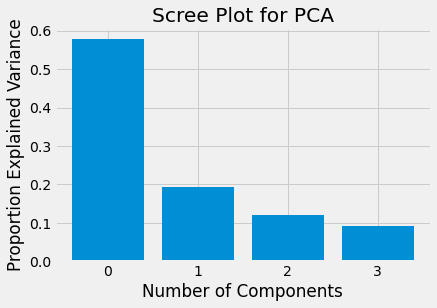

In [189]:
index = np.arange(4)
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree Plot for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Proportion Explained Variance')

In [191]:
scaler = StandardScaler().fit(X)
X_sc = scaler.transform(X)


In [192]:
kmeans = KMeans(n_clusters=6).fit(X_sc)
y_pred = kmeans.predict(X_sc)

In [193]:
k_means_2 = KMeans(n_clusters=2).fit(X_sc)
k_means_3 = KMeans(n_clusters=3).fit(X_sc)
k_means_4 = KMeans(n_clusters=4).fit(X_sc)
k_means_5 = KMeans(n_clusters=5).fit(X_sc)
k_means_6 = KMeans(n_clusters=6).fit(X_sc)
k_means_7 = KMeans(n_clusters=7).fit(X_sc)
k_means_8 = KMeans(n_clusters=8).fit(X_sc)
k_means_9 = KMeans(n_clusters=9).fit(X_sc)
k_means_10 = KMeans(n_clusters=10).fit(X_sc)
k_means_11 = KMeans(n_clusters=11).fit(X_sc)
k_means_12 = KMeans(n_clusters=12).fit(X_sc)

k_list = [k_means_2, k_means_3, k_means_4, k_means_5, k_means_6, k_means_7, k_means_8, k_means_9, k_means_10, k_means_11, k_means_12]

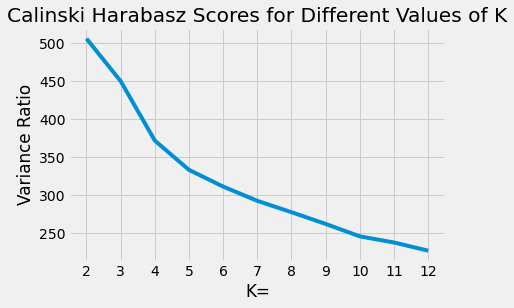

In [195]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(X_sc, labels))

plt.plot([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], CH_score)
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

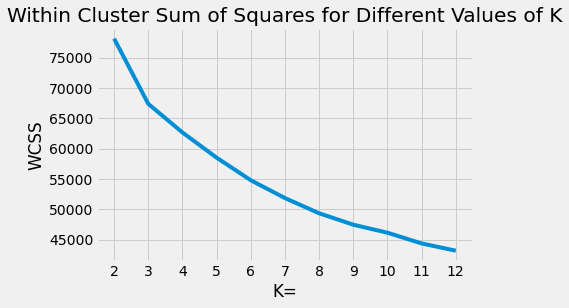

In [196]:
wcss_score= []
for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

plt.plot([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], wcss_score)
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.title('Within Cluster Sum of Squares for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

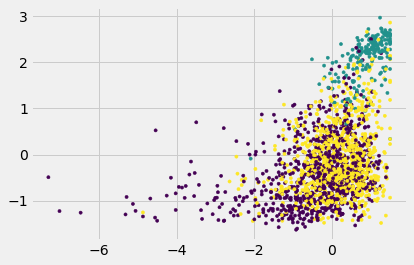

In [205]:
agg_clust = AgglomerativeClustering(n_clusters=3)
assigned_clust = agg_clust.fit_predict(X_sc)
plt.scatter(X_sc[:,0], X_sc[:,1], c=assigned_clust, s=10)

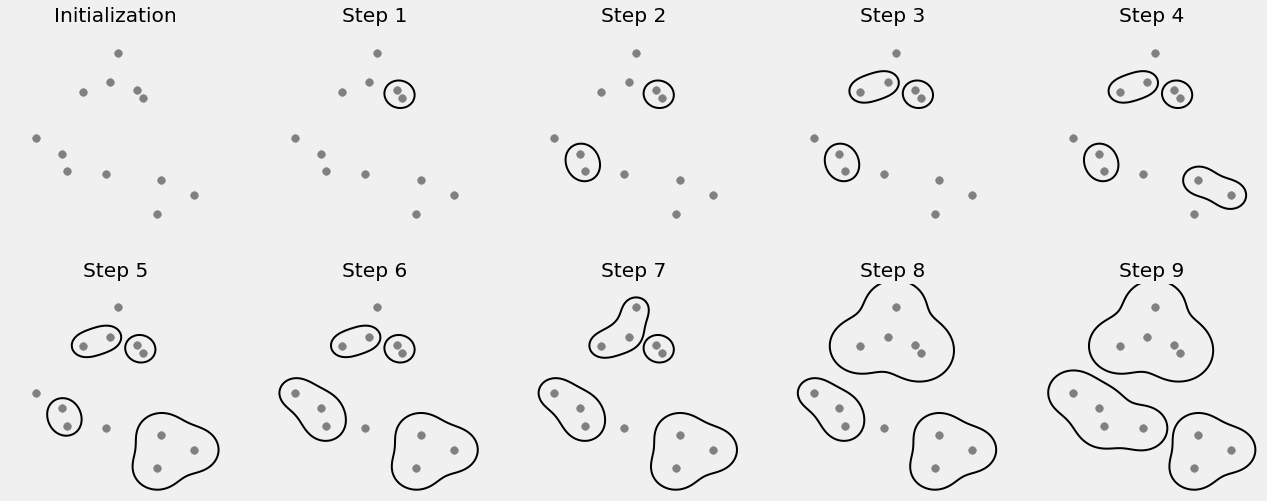

In [200]:
plot_agglomerative_algorithm()

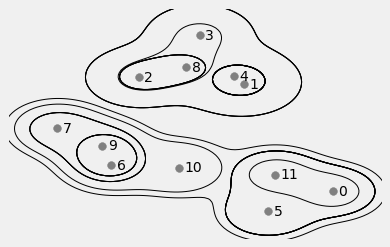

In [201]:
plot_agglomerative()

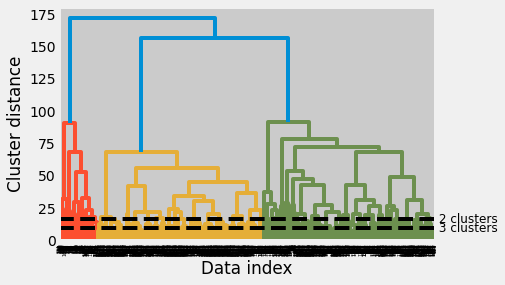

In [204]:
linkage_array = ward(X_sc1718)
dendrogram(linkage_array)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel('Data index')
plt.ylabel('Cluster distance')
plt.show()

In [ ]:
plt.scatter